In [90]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np


In [91]:
#dataset preparation
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))
            ])
mnist = datasets.MNIST(root='data', download=True, transform=transform)
#batch_size
batch_size=64
dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [92]:
MODEL_NAME = 'MNIST_GAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("MODEL_NAME = {}, DEVICE = {}".format(MODEL_NAME, DEVICE))

MODEL_NAME = MNIST_GAN, DEVICE = cuda


Model Definition

In [93]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    #nn.Embedding() : similar to the one hot 
    self.label_embedding = nn.Embedding(10, 10)

    self.make_mnist = nn.Sequential(
        nn.Linear(110, 256),
        nn.LeakyReLU(0.2, inplace=False),
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2, inplace=False),
        nn.Linear(512, 1024),
        nn.Linear(1024, 28*28),
        nn.Tanh()
    )
  def forward(self, inputs, labels):
    inputs = inputs.view(inputs.size(0),100)
    emdedded_label = self.label_embedding(labels)
    new_input = torch.cat([inputs,emdedded_label],1)
    output = self.make_mnist(new_input)
    return output.view(-1,1,28,28)

In [94]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    #nn.Embedding() : similar to the one hot
    self.label_embedding = nn.Embedding(10,10)

    self.division = nn.Sequential(
        nn.Linear(28*28+10,1024),
        nn.LeakyReLU(0.2, inplace=False),
        nn.Dropout(inplace=True),
        nn.Linear(1024,512),
        nn.LeakyReLU(0.2, inplace=False),
        nn.Dropout(inplace=True),
        nn.Linear(512,256),
        nn.LeakyReLU(0.2, inplace=False),
        nn.Dropout(inplace=True),
        nn.Linear(256,1),
        nn.Sigmoid()
    )
  def forward(self, inputs, labels):
    inputs = inputs.view(inputs.size(0), 784)
    emdedded_label = self.label_embedding(labels)
    new_input = torch.cat([inputs,emdedded_label],1)
    output = self.division(new_input)
    return output

In [95]:
G=Generator().to(DEVICE)
D=Discriminator().to(DEVICE)

In [96]:
# utility function to measure time
import time
import math

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s/60)
  s -= m*60
  return '%dm %ds'%(m,s)

In [97]:
criterion = nn.BCELoss()
G_optim = Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optim = Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [98]:
D_losses=[]
G_losses=[]

In [99]:
max_epoch = 5
step = 0 
plot_every = 200

total_D_loss = 0
total_G_loss = 0

start = time.time()

for epoch in range(max_epoch):
  for real_data, label in dataloader:
    x = real_data.to(DEVICE)
    real_labels = label.to(DEVICE)

    target_real = torch.ones(batch_size, 1)
    target_fake = torch.zeros(batch_size, 1)
    y_real, y_fake = target_real.to(DEVICE), target_fake.to(DEVICE)
    
    ###I. Discriminator training###
    D_result_from_real = D(x,real_labels) # real image
    D_loss_real = criterion(D_result_from_real, y_real) 

    z=torch.randn((batch_size, 100))
    x_fake = z.to(DEVICE)
    fake_labels = torch.LongTensor(np.random.randint(0,10,batch_size)).to(DEVICE)

    
    fake_data = G(x_fake,fake_labels) # make fake images and labels
    D_result_from_fake = D(fake_data,fake_labels) 
    D_loss_fake = criterion(D_result_from_fake,y_fake)


    D_loss = D_loss_real + D_loss_fake # sum of losses
    total_D_loss += D_loss.item()

    D.zero_grad()
    D_loss.backward()
    D_optim.step()
    

    ###II. Generator training###
    z = torch.randn((batch_size, 100))
    x_fake = z.to(DEVICE)
    fake_labels = torch.LongTensor(np.random.randint(0,10,batch_size)).to(DEVICE)

    
    fake_data = G(x_fake, fake_labels) # make fake images and labels
    D_result_from_fake = D(fake_data, fake_labels)
    G_loss = criterion(D_result_from_fake, y_real)
    total_G_loss += G_loss.item()

    G.zero_grad()
    G_loss.backward()
    G_optim.step()

    if step % 500 == 0 :
      print('Epoch ({}): {}/{}, Step: {}, G_Loss: {}, D_Loss: {}'.format(timeSince(start), epoch, max_epoch, step, G_loss.item(), D_loss.item()))
    if (step + 1) % plot_every == 0:
      D_losses.append(total_D_loss / plot_every)
      total_D_loss = 0
      G_losses.append(total_G_loss / plot_every)
      total_G_loss = 0

    step+=1

Epoch (0m 0s): 0/5, Step: 0, G_Loss: 0.6935402750968933, D_Loss: 1.4029486179351807
Epoch (0m 10s): 0/5, Step: 500, G_Loss: 2.4801087379455566, D_Loss: 0.6935577988624573
Epoch (0m 20s): 1/5, Step: 1000, G_Loss: 1.5416951179504395, D_Loss: 0.6257813572883606
Epoch (0m 30s): 1/5, Step: 1500, G_Loss: 2.0676941871643066, D_Loss: 0.6320791244506836
Epoch (0m 40s): 2/5, Step: 2000, G_Loss: 1.7204859256744385, D_Loss: 0.8006564378738403
Epoch (0m 50s): 2/5, Step: 2500, G_Loss: 2.472304105758667, D_Loss: 0.7180084586143494
Epoch (1m 0s): 3/5, Step: 3000, G_Loss: 1.0893852710723877, D_Loss: 0.8881281614303589
Epoch (1m 10s): 3/5, Step: 3500, G_Loss: 1.5644221305847168, D_Loss: 0.9268059730529785
Epoch (1m 20s): 4/5, Step: 4000, G_Loss: 1.4664103984832764, D_Loss: 0.835142970085144
Epoch (1m 31s): 4/5, Step: 4500, G_Loss: 2.1096889972686768, D_Loss: 1.116769552230835


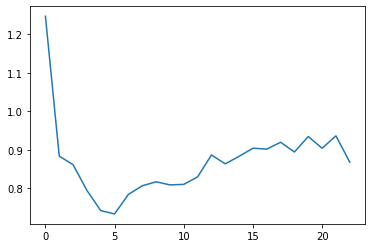

In [100]:
import matplotlib.pyplot as plt
#D_losses
plt.figure()
plt.plot(D_losses)

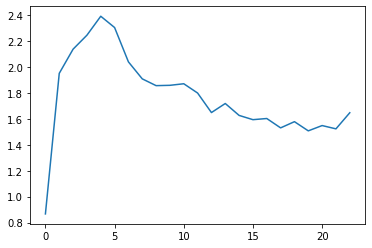

In [101]:
#G_losses
plt.figure()
plt.plot(G_losses)

In [102]:
#sample images
n = 10 
z = torch.randn((n*n),100).to(DEVICE)
labels = torch.LongTensor([i for i in range(10) for _ in range(10)]).to(DEVICE)
Generated_image = G(z,labels)
image_numpy=Generated_image.view(n*n, 28, 28).cpu().data.numpy()

def show_images(image,s=5):
  print(image.shape)
  fig=plt.figure(figsize=(10, 10))
  columns = s
  rows = s
  for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(image[i-1],cmap='gray')
  plt.show()



(100, 28, 28)


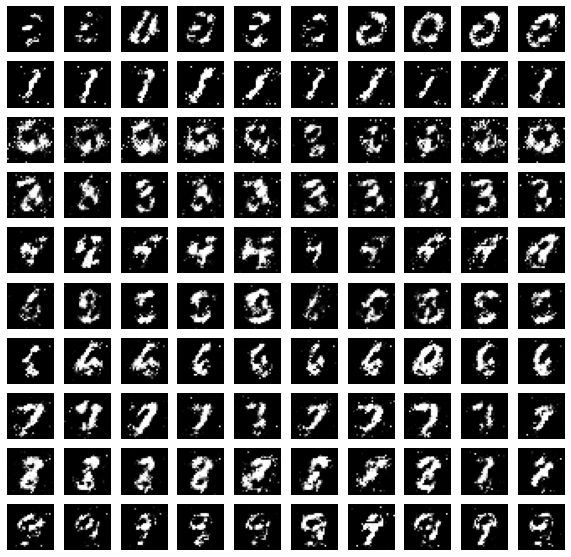

In [103]:
show_images(image_numpy,s=10)